# Market Microstructure

_UNDER CONSTRUCTION_


- NYSE Daily TAQ tick data
- Intraday spreads: quoted, effective, price impact, realized; Lee-Ready tick test
- Intraday volatility: variance ratio, Parkinsons (HL) and Klass-Garman (OHLC) methods


In [4]:
import numpy as np
import pandas as pd
import time
from pandas import DataFrame, Series
from matplotlib import colors
import matplotlib.pyplot as plt
from tqdm import tqdm
import multiprocessing
from finds.database.sql import SQL
from finds.database.redisdb import RedisDB
from finds.structured.crsp import CRSP
from finds.busday import BusDay
from finds.readers.taq import opentaq, itertaq, bin_trades, bin_quotes, TAQ
from finds.plots import plot_time
from finds.misc.show import row_formatted, Show
from finds.filters import weighted_average
from finds.finance import Volatility
from finds.unstructured.store import Store
from secret import credentials, paths

VERBOSE = 0
show = Show(ndigits=4, latex=None)
%matplotlib inline

In [5]:
sql = SQL(**credentials['sql'], verbose=VERBOSE)
user = SQL(**credentials['user'], verbose=VERBOSE)
bday = BusDay(sql)
rdb = RedisDB(**credentials['redis'])
crsp = CRSP(sql, bday, rdb=rdb, verbose=VERBOSE)
imgdir = paths['images']
taqdir = paths['taq']
storedir = paths['downloads'] / 'store'
open_t = pd.to_datetime('1900-01-01T9:30')    # exclude <= 
close_t = pd.to_datetime('1900-01-01T16:00')  # exclude >
EPSILON = 1e-15
dates = [20191007, 20191008, 20180305, 20180306]

Last FamaFrench Date 2023-06-30 00:00:00


__Loop over stocks in TAQ daily__

In [ ]:
"""Non-parallel code
# filter by usual CRSP investment universe
for d, date in enumerate(dates):
    store = Store(storedir / str(date), verbose=VERBOSE)
    master, trades, quotes = opentaq(date, taqdir)

    # screen on CRSP universe
    univ = crsp.get_universe(date)\
               .join(crsp.get_section(dataset='names',
                                      fields=['ncusip', 'permco', 'exchcd'],
                                      date_field='date',
                                      date=date,
                                      start=0), how='inner')\
               .sort_values(['permco', 'ncusip'])

    # drop duplicate share classes (same permco): keep largest cap
    dups = master['CUSIP'].str\
                          .slice(0, 8)\
                          .isin(univ.loc[univ.duplicated(['permco'],keep=False),
                                         'ncusip'])
    shareclass.extend(master[dups].to_dict(orient='index').values())    
    univ = univ.sort_values(['permco', 'cap'], na_position='first')\
               .drop_duplicates(['permco'], keep='last')\
               .reset_index()\
               .set_index('ncusip', drop=False)

    # Iterate by symbol over Daily Taq trades, nbbo and master files
    for ct, cq, mast in itertaq(trades,
                                quotes,
                                master,
                                cusips=univ['ncusip'],
                                open_t=open_t,
                                close_t=None,
                                verbose=VERBOSE):
        header = {'date':date}
        header.update(univ.loc[mast['CUSIP'][:8],
                               ['permno','decile','exchcd','siccd']])
        header.update(mast[['Symbol', 'Round_Lot']])
        store[header['Symbol']] = dict(header=header, ct=ct, cq=cq, mast=mast)
    quotes.close()
    trades.close()

# combine into large dataframe
daily_df = DataFrame(daily_all)
bins_df = {k: DataFrame(bins_all[k]) for k in bins_all.keys()}
"""

# Intraday liquidity

Compute intraday liquidity measures

In [23]:
intervals = ([(v, 's') for v in [1, 2, 5, 15, 30]]
             + [(v, 'm') for v in [1, 2, 5]])
max_num = 100000
bin_keys = ['effective', 'realized', 'impact',
            'quoted', 'volume', 'offersize', 'bidsize',
            'ret', 'retq', 'counts']
def intraday(date):
    """Compute intraday liquidity for one date, parallelizable"""
    store = Store(storedir / str(date), verbose=VERBOSE)
    symbols = sorted(store)
    shareclass = []
    daily_all = []
    bins_all = {k: [] for k in bin_keys}
    for num, symbol in enumerate(symbols):
        if num >= max_num:
            return (daily_all, bins_all)
        header, ct, cq, mast = store[symbol]

        # Compute and collect daily and bin statistics at all intervals
        daily = header.copy()   # to collect current stock's daily stats

        # Compute effective spreads by large and small trade sizes
        med_volume = mast['Round_Lot'] * (cq['Best_Bid_Size'].median()
                                          + cq['Best_Offer_Size'].median()) / 2.
        data = ct.loc[(ct.index > open_t) & (ct.index < close_t),
                      ['Trade_Price', 'Prevailing_Mid', 'Trade_Volume']]
        eff_spr = data['Trade_Price'].div(data['Prevailing_Mid']).sub(1).abs()
        eff_large = eff_spr[data['Trade_Volume'].ge(med_volume).to_numpy()]
        daily['large_trades'] = len(eff_large)
        daily['large_volume'] = data.loc[data['Trade_Volume'].ge(med_volume),
                                'Trade_Volume'].mean()
        daily['large_spread'] = eff_large.mean()
        eff_small = eff_spr[data['Trade_Volume'].lt(med_volume)]
        daily['small_trades'] = len(eff_small)
        daily['small_volume'] = data.loc[data['Trade_Volume'].lt(med_volume),
                                'Trade_Volume'].mean()
        daily['small_spread'] = eff_small.mean()

        v, u = intervals[-1]
        for (v, u) in intervals:
            bt = bin_trades(ct, v, u, open_t=open_t, close_t=close_t)
            bq = bin_quotes(cq, v, u, open_t=open_t, close_t=close_t)
            daily[f"tvar{v}{u}"] = bt['ret'].var(ddof=0) * len(bt)
            daily[f"tvarHL{v}{u}"] = ((Volatility.HL(bt['maxtrade'],
                                                    bt['mintrade'])**2)
                                      * len(bt))
            daily[f"tvarOHLC{v}{u}"] = ((Volatility.OHLC(bt['first'],
                                                         bt['maxtrade'],
                                                         bt['mintrade'],
                                                         bt['last'])**2)
                                        * len(bt))
            daily[f"qvar{v}{u}"] = bq['retq'].var(ddof=0) * len(bq)
            daily[f"qvarHL{v}{u}"] = ((Volatility.HL(bq['maxmid'],
                                                     bq['minmid'])**2)
                                      * len(bq))
            daily[f"qvarOHLC{v}{u}"] = ((Volatility.OHLC(bq['firstmid'],
                                                         bq['maxmid'],
                                                         bq['minmid'],
                                                         bq['mid'])**2)
                                        * len(bq))
            daily[f"tunch{v}{u}"] = np.mean(np.abs(bt['ret']) < EPSILON)
            daily[f"qunch{v}{u}"] = np.mean(np.abs(bq['retq']) < EPSILON)
            daily[f"tzero{v}{u}"] = np.mean(bt['counts'] == 0)


        # Collect final (i.e. 5 minute bins) bt and bq intraday series
        df = bq.join(bt, how='left')
        for s in ['effective', 'realized', 'impact', 'quoted']:
            bins_all[s].append({**header,
                                **(df[s]/df['mid']).to_dict()})
        for s in ['volume', 'offersize', 'bidsize', 'ret', 'retq', 'counts']:
            bins_all[s].append({**header,
                                **df[s].to_dict()})

        # Collect daily means
        daily.update(df[['bidsize', 'offersize', 'quoted', 'mid']].mean())
        daily.update(df[['volume', 'counts']].sum())
        daily.update(weighted_average(df[['effective', 'impact', 'realized',
                                            'vwap', 'volume']],
                                        weights='volume'))
        daily_all.append(daily)




In [ ]:
# Run intraday jobs in parallel pool
p = multiprocessing.Pool()
data = p.map(intraday, dates)
p.close()


In [ ]:
# Combine data
daily_df = pd.concat([DataFrame(data[j][0]) for j in range(len(data))],
                     ignore_index=True)
bins_df = {k: pd.concat([DataFrame(data[j][1][k]) for j in range(len(data))],
                        ignore_index=True)
           for k in bin_keys}


In [7]:
# Initialize folder to store data   
store = Store(paths['scratch'])


In [ ]:
# Save extracted data 
store.dump(daily_df, 'tick.daily')
store.dump(bins_df, 'tick.bins')
#store.dump(shareclass, 'tick.shrcls')

In [8]:
# Fetch extracted data    
daily_df = store.load('tick.daily')
bins_df = store.load('tick.bins')

__Daily average of liquidity measures, by market cap__

In [9]:
# group by market cap (NYSE deciles 1-3, 4-6, 7-9, 10) and exchange listed
daily_df['Size'] = pd.cut(daily_df['decile'],
                          [0, 3.5, 6.5, 9.5, 11],
                          labels=['large', 'medium', 'small', 'tiny'])
groupby = daily_df.groupby(['Size'])

In [10]:
# collect results for each metric
results = {}    # to collect results as dict of {column: Series}
formats = {}    # and associated row formatter string
results.update(groupby['mid']\
               .count()\
               .rename('Number of Stock/Days').to_frame())
formats.update({'Number of Stock/Days': '{:.0f}'})

In [11]:
result = groupby[['mid', 'vwap']].mean()   # .quantile(), and range
result.columns = ['Midquote Price', "VWAP"]
formats.update({k: '{:.2f}' for k in result.columns})
results.update(result)

In [12]:
result = groupby[['counts', 'volume']].mean()
result.columns = ['Number of trades', "Volume (shares)"]
formats.update({k: '{:.0f}' for k in result.columns})
results.update(result)

In [13]:
result = np.sqrt(groupby[['tvar5m', 'qvar5m', 'tvarHL5m', 'qvarHL5m',
                          'tvarOHLC5m', 'qvarOHLC5m']].mean())
result.columns = ['Volatility(trade price)', "Volatility(midquote)",
                  'Volatility(HL trade price)', "Volatility(HL midquote)",
                  'Volatility(OHLC trade price)', "Volatility(OHLC midquote)"]
formats.update({k: '{:.4f}' for k in result.columns})
results.update(result)

In [14]:
result = groupby[['offersize', 'bidsize']].mean()
result.columns = [s.capitalize() + ' (lots)' for s in result.columns]
formats.update({k: '{:.1f}' for k in result.columns})
results.update(result)

In [15]:
spr = ['quoted', 'effective', 'impact', 'realized']
result = groupby[spr].mean()
result.columns = [s.capitalize() + ' $ spread' for s in spr]
formats.update({k: '{:.4f}' for k in result.columns})
results.update(result)

In [16]:
rel = [s.capitalize() + ' (% price)' for s in spr]
daily_df[rel] = daily_df[spr].div(daily_df['mid'], axis=0)  # scale spreads
result = 100*groupby[rel].mean()
formats.update({k: '{:.4f}' for k in result.columns})
results.update(result)

In [17]:
# summarize large and small trade effective spreads
spr = ['large_spread', 'small_spread']
result = 100*groupby[spr].mean()
result.columns = ['Large trade (% spread) ', 'Small trade (% spread) ']
formats.update({k: '{:.4f}' for k in result.columns})
results.update(result)

In [18]:
spr = ['large_trades', 'small_trades']
result = groupby[spr].mean()
result.columns = ['Large trade (# trades) ', 'Small trade (# trades) ']
formats.update({k: '{:.0f}' for k in result.columns})
results.update(result)

In [19]:
spr = ['large_volume', 'small_volume']
result = groupby[spr].mean()
result.columns = ['Large trade (avg volume) ', 'Small trade (avg volume) ']
formats.update({k: '{:.0f}' for k in result.columns})
results.update(result)

In [20]:
# display table of results
show(row_formatted(DataFrame(results).T, formats),
     caption="Average Liquidity by Market Cap")

Size,large,medium,small,tiny
Average Liquidity by Market Cap,,,,
Number of Stock/Days,2063,2572,4297,4618
Midquote Price,128.98,64.91,27.76,7.92
VWAP,128.97,64.92,27.75,7.90
Number of trades,25178,8407,3658,837
Volume (shares),3031056,995483,533736,254773
Volatility(trade price),0.0145,0.0211,0.0359,0.0807
Volatility(midquote),0.0152,0.0223,0.0355,0.0918
Volatility(HL trade price),0.0176,0.0217,0.0335,0.0690
Volatility(HL midquote),0.0144,0.0198,0.0288,0.0594


In [21]:
## Summarize unchanged midquote and trade price, and zero-volume bins
def plot_helper(result, xticks, keys, legend, xlabel, title, ylim=[],
                figsize=(5,3), num=1, fontsize=8):
    """helper to plot bar graphs"""
    fig, ax = plt.subplots(num=num, clear=True, figsize=figsize)
    result.plot(kind='bar',
                fontsize=fontsize,
                rot=0,
                width=0.8,
                xlabel='',
                ax=ax)
    if ylim:
        ax.set_ylim(*ylim)
    ax.set_xticklabels(xticks, fontsize=fontsize)
    ax.legend(keys, loc='upper left', bbox_to_anchor=(1.0, 1.0), 
              fontsize=fontsize, title=legend, title_fontsize=8)
    ax.set_xlabel(xlabel, fontsize=fontsize + 2)
    ax.set_title(title, fontsize=fontsize + 2)
    plt.subplots_adjust(right=0.8, bottom=0.15)
    plt.tight_layout()
    return ax

In [24]:
xticks = [f"{v}{u}" for v, u in intervals]   # x-axis: bin lengths
keys = list(groupby.indices.keys())          # legend labels


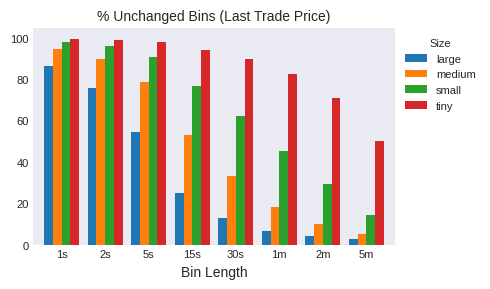

In [25]:
labels = [f"tunch{v}{u}" for v, u in intervals]
result = groupby[labels].median()*100
ax = plot_helper(result.T,
                 title="% Unchanged Bins (Last Trade Price)",
                 xticks=xticks,
                 xlabel="Bin Length",
                 keys=keys,
                 legend='Size',
                 num=1)
plt.savefig(imgdir / 'tunch.jpg')

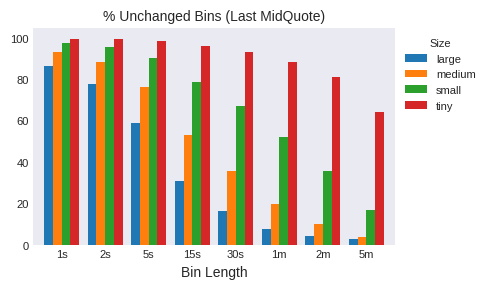

In [26]:
labels = [f"qunch{v}{u}" for v, u in intervals]
result = groupby[labels].median()*100
ax = plot_helper(result.T,
                 title="% Unchanged Bins (Last MidQuote)",
                 xticks=xticks,
                 xlabel="Bin Length",
                 keys=keys,
                 legend='Size',
                 num=2)
plt.savefig(imgdir / 'qunch.jpg')

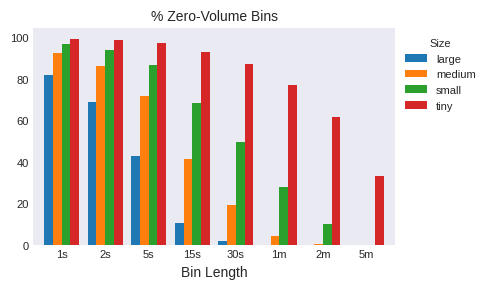

In [27]:
labels = [f"tzero{v}{u}" for v, u in intervals]
result = groupby[labels].median()*100
ax = plot_helper(result.T,
                 title="% Zero-Volume Bins",
                 xticks=xticks,
                 xlabel="Bin Length",
                 keys=keys,
                 legend='Size',
                 num=3)
plt.savefig(imgdir / 'tzero.jpg')

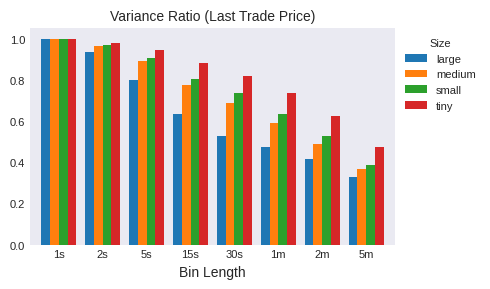

In [28]:
labels = [f"tvar{v}{u}" for v, u in intervals]
result = groupby[labels].median()
result = result.div(result['tvar1s'].values, axis=0)
ax = plot_helper(result.T,
                 title="Variance Ratio (Last Trade Price)",
                 xticks=xticks,
                 xlabel="Bin Length",
                 keys=keys,
                 legend='Size',
                 num=4)
plt.savefig(imgdir / 'tvratio.jpg')

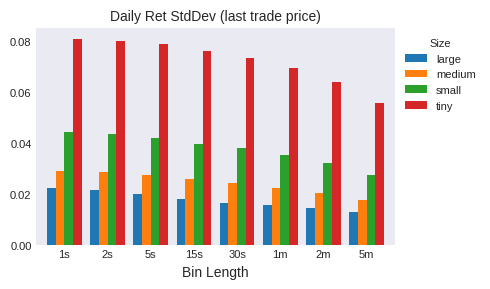

In [29]:
labels = [f"tvar{v}{u}" for v, u in intervals]
result = np.sqrt(groupby[labels].median())
ax = plot_helper(result.T,
                 title="Daily Ret StdDev (last trade price)",
                 xticks=xticks,
                 xlabel="Bin Length",
                 keys=keys,
                 legend='Size',
                 num=5)
plt.savefig(imgdir / 'tstd.jpg')

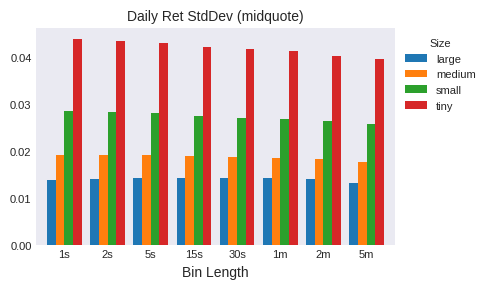

In [30]:
labels = [f"qvar{v}{u}" for v, u in intervals]
result = np.sqrt(groupby[labels].median())
ax = plot_helper(result.T,
                 title="Daily Ret StdDev (midquote)",
                 xticks=xticks,
                 xlabel="Bin Length",
                 keys=keys,
                 legend='Size',
                 num=6)
plt.savefig(imgdir / 'qstd.jpg')

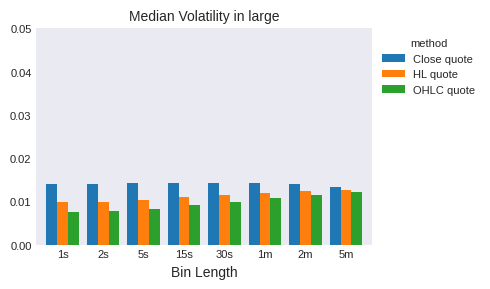

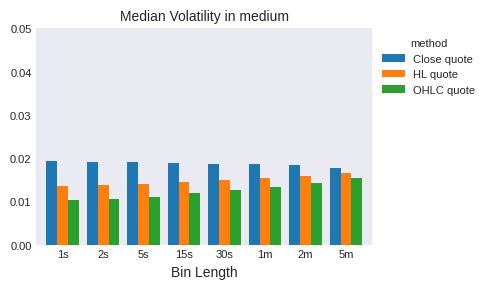

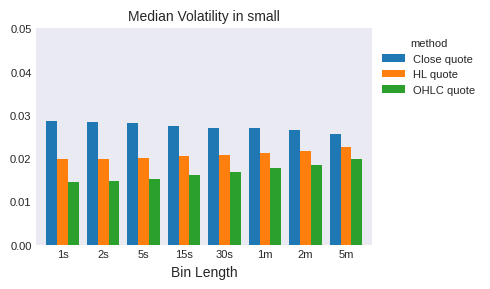

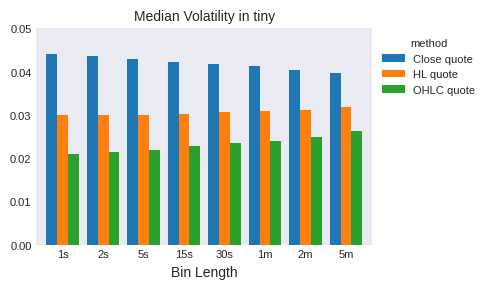

In [31]:
## Compare methods of volatility estimates, by interval and market cap
for ifig, (split_label, split_df) in enumerate(groupby):
    vol_df = np.sqrt(split_df[[c for c in daily_df.columns if "qvar" in c]])
    result = []
    for col in [c for c in vol_df.columns if "qvar" in c]:
        if col[4] == 'H':
            m = 'HL'
        elif col[4] == 'O':
            m = 'OHLC'
        else:
            m = 'Close'
        result.append({'method': m + ' ' + {'t': 'trade', 'q': 'quote'}[col[0]],
                       'interval': (int("".join(filter(str.isdigit, col)))
                                    * (60 if col[-1] == 'm' else 1)),
                       'val': vol_df[col].median()})
    result = DataFrame.from_dict(result, orient='columns')\
        .pivot(index='interval', columns='method', values='val')
    ax = plot_helper(result,
                     title="Median Volatility in " + " ".join(split_label),
                     xticks=xticks,
                     xlabel="Bin Length",
                     keys=result.columns,
                     num=1+ifig,
                     ylim=[0.0 ,0.05],
                     legend='method')
    plt.savefig(imgdir / ('tick_' + "_".join(split_label) + '.jpg'))

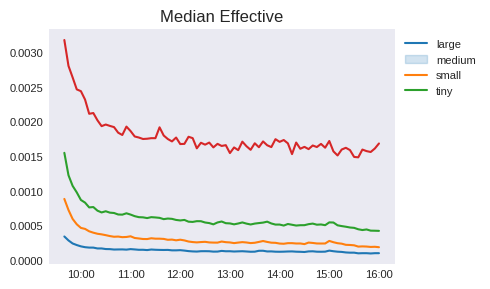

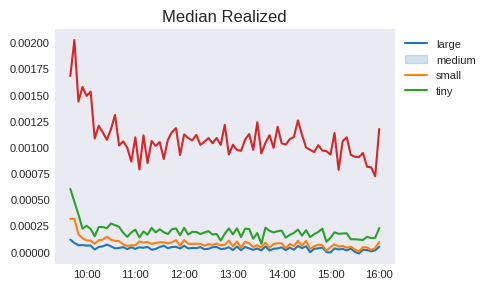

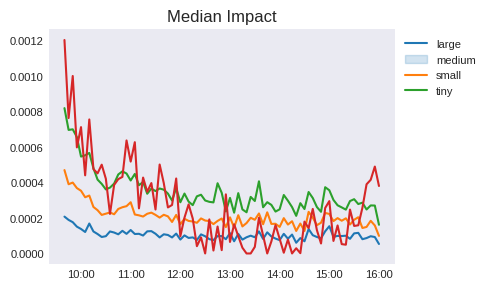

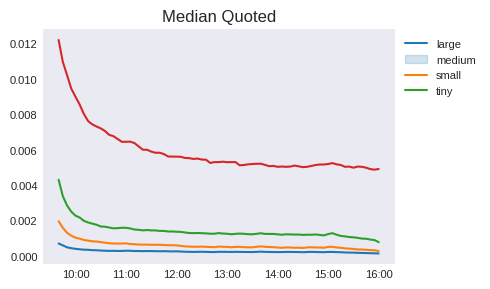

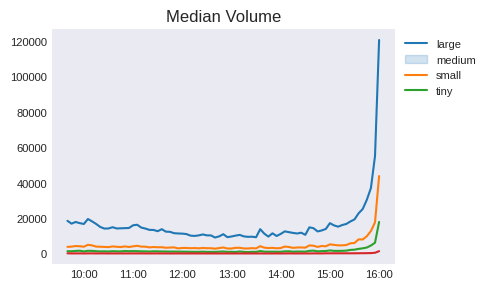

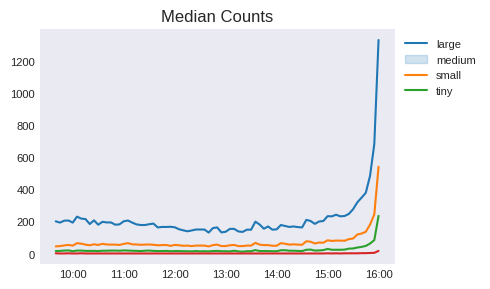

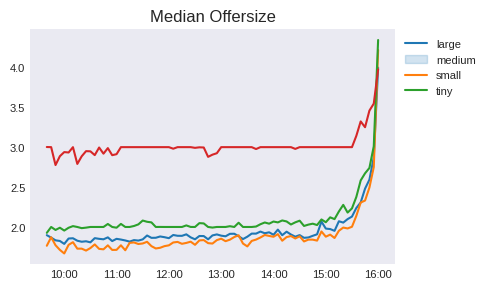

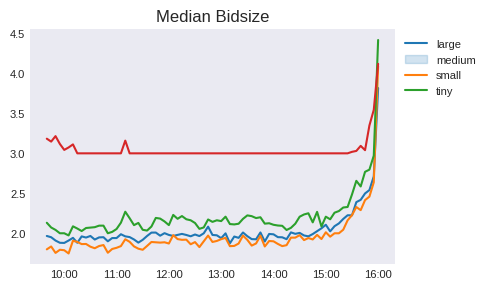

In [32]:
## Plot intraday spreads, depths and volumes
keys = ['effective', 'realized', 'impact', 'quoted', 
        'volume', 'counts', 'offersize', 'bidsize']
for num, key in enumerate(keys):
    df = bins_df[key].drop(columns=['Round_Lot', 'Symbol'])
    df.index = list(zip(df['permno'], df['date']))
        
    # Group by market cap
    df['Size'] = pd.cut(df['decile'],
                        [0, 3.5, 6.5, 9.5, 11],
                        labels=['large', 'medium', 'small', 'tiny'])
    df = df.drop(columns=['date', 'permno', 'decile', 'exchcd', 'siccd'])\
           .dropna()\
           .groupby(['Size'])\
           .median().T
    fig, ax = plt.subplots(1, 1, num=num+1, clear=True, figsize=(5, 3))
    plot_time(df.iloc[1:],
              title='Median ' + key.capitalize(),
              ax=ax, 
              fontsize=8,
              loc1='upper center',
              legend1=None)
    ax.legend(df.columns, 
              loc='upper left', bbox_to_anchor=(1.0, 1.0), 
              fontsize=8)
    plt.subplots_adjust(right=0.8)
    plt.tight_layout()
    plt.savefig(imgdir / (key + '.jpg'))